## What we know about the data already

I merged the data from the indego website https://www.rideindego.com/about/data/

The data ranges from the start of the program in _start_date_ 2015 through to _end date_2020_. Per the website above trips shorter than 1 minute have been removed and trip length has been capped at 24 hours. I will keep this in mind as I consider outliers. 

We do not have any information other than start and end points, about the routes that riders took.

We also must consider that this is a biased dataset. These data represents a specific population of bikers. 

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
pd.options.display.float_format = '{:.3f}'.format

In [2]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [3]:
def print_nulls(df):
    
    return df.isnull().sum()*100/df.isnull().isnull().count()

In [4]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [5]:
raw_data = pd.read_csv(r'data/indego/indego-trips-all.csv')

/home/owen/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
df = raw_data.copy()

In [19]:
# Type errors let us know that we may have some problems with missing or improperly typed data. 
# We already know this from merging our data.

In [20]:
# Drop the unique identifier
df.drop('trip_id', axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594529 entries, 0 to 3594528
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   duration             int64  
 1   start_time           object 
 2   end_time             object 
 3   start_station_id     float64
 4   start_lat            object 
 5   start_lon            object 
 6   end_station_id       float64
 7   end_lat              object 
 8   end_lon              object 
 9   bike_id              object 
 10  plan_duration        float64
 11  trip_route_category  object 
 12  passholder_type      object 
 13  start_station        float64
 14  end_station          float64
 15  bike_type            object 
dtypes: float64(5), int64(1), object(10)
memory usage: 438.8+ MB


In [22]:
df.head()

,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type
0,60,2015-04-23 07:44:00,4/23/15 7:45,3046.000,39.950,-75.145,3046.000,39.950,-75.145,3350.000,30.000,Round Trip,Indego30,nan,nan,NaN
1,60,2015-04-23 07:45:00,4/23/15 7:46,3046.000,39.950,-75.145,3046.000,39.950,-75.145,3350.000,30.000,Round Trip,Indego30,nan,nan,NaN
2,120,2015-04-23 07:46:00,4/23/15 7:48,3057.000,39.964,-75.180,3057.000,39.964,-75.180,3282.000,0.000,Round Trip,Walk-up,nan,nan,NaN
3,60,2015-04-23 10:13:00,4/23/15 10:14,3004.000,39.954,-75.164,3004.000,39.954,-75.164,3350.000,30.000,Round Trip,Indego30,nan,nan,NaN
4,180,2015-04-23 10:14:00,4/23/15 10:17,3004.000,39.954,-75.164,3004.000,39.954,-75.164,2716.000,30.000,Round Trip,Indego30,nan,nan,NaN


## Data Cleaning

In [23]:
# Bike_id values
# Here there are just a few badly formated values that are easily retrieved
index = df[df['bike_id'] == '03556A'].index
df.loc[index, 'bike_id'] = 3556

# 4 values asking to be deleted; we oblidge
index = df[df['bike_id'] == 'delete me'].index
df.drop(index, inplace=True)

df['bike_id'] = pd.to_numeric(df['bike_id'])

In [24]:
# Encode trip type
mask = df['trip_route_category'] == 'One Way'
df.loc[mask, 'trip_route_category'] = 0

mask = df['trip_route_category'] == 'Round Trip'
df.loc[mask, 'trip_route_category'] = 1

df['trip_route_category'] = pd.to_numeric(df['trip_route_category'])

In [25]:
# The formatting on this column changed part way through the dataset
# Fill into one column from the other
mask = df['start_station'].isna()
df.loc[mask, 'start_station'] = df['start_station_id']

# and for the end stations
mask = df['end_station'].isna()
df.loc[mask, 'end_station'] = df['end_station_id']

# drop the other columns
df.drop(['start_station_id', 'end_station_id'], axis=1, inplace=True)

In [26]:
# For now passholder type and plan duration are not useful. Check how ballanced our level are in some of our categorical variables
df.drop(['passholder_type', 'plan_duration'], axis=1, inplace=True)

Missing data for the beginning and ending longitude and latitude of trips overlaps significantly with trips that involve station 3000. This is a virtual station used for system administration. In other cases these data might be outliers to be discarded but in this case these trips may be significant as an unusual trip might present more wear and tear on the bikes. For now I will aggregate the number of trips each bike makes to station 3000 then drop the rows since there is no way to impute the start and end locations. 

In [27]:
trips_to_3000 = df[df['end_station'] == 3000
                  ].drop_duplicates(subset=['bike_id', 'end_time']
                                   ).groupby('bike_id').agg(trips_to_3000 = ('end_station', 'count'))


trips_from_3000 = df[df['start_station'] == 3000].groupby('bike_id').agg(
    trips_from_3000 = ('start_station', 'count'))



_3000 = trips_from_3000.join(trips_to_3000)

# Write the data to file to use later
_3000.to_csv(r'_3000_trips.csv', index=False)

In [ ]:
# Now the location data can be cleaned
# Luckily the problem is missing values in a small proportion of columns
 
cols = ['start_lat', 'start_lon', 'end_lat', 'end_lon']

for col in cols:
    df[df[col] == r'\N'] = np.nan
    
    df[col] = pd.to_numeric(df[col])

# entries that have 0 listed for both end coordinates
index = df[df['end_lat'] == 0].index
df.drop(index, inplace=True)

# entries that have 0 listed for both start coordinates 
index = df[df['start_lat'] == 0].index
df.drop(index, inplace=True)

#Two entries have negative latitude values for the start and end, they can be retrieved
mask = df['start_lat'] < 0
df.loc[mask, 'start_lat'] = df.loc[mask, 'start_lat'] * -1


# Three entries where only the end latitude is negative
mask = df['end_lat'] < 0
df.loc[mask, 'end_lat'] = df.loc[mask, 'end_lat'] *-1

In [ ]:
# Bike type column
# This column is introduced in 2018-q3 report. This is also when a second bike type was introduced
# Therefore we can assume that all the trips before that were on standard bikes. Nulls only appear for this 
# time before there were electric bikes so it is safe to fill all of them
df['bike_type'] = df['bike_type'].fillna('standard')

In [ ]:
# Drop the few remaining nulls
df = df.dropna()

In [ ]:
# There are a small number of trips that appear to be duplicates
df[['start_time', 'bike_id']].duplicated().value_counts()

In [ ]:
df = df.drop_duplicates(['start_time', 'bike_id'])

In [ ]:
# What about trips that end at the same time at the same station?
df[['end_time', 'bike_id', 'end_station']].duplicated().value_counts()

In [ ]:
df = df.drop_duplicates(['end_time', 'bike_id'])

In [ ]:
# Next the timestamp values
df['start_time'] = df['start_time'].astype('datetime64')
df['end_time'] = df['end_time'].astype('datetime64')

# Simply recalulate the duration
# The result will be in minutes because that is what all of our start and stop times are rounded to
df['duration'] = (df['end_time'] - df['start_time']).dt.seconds / 60

# A few trips with duration of less than 1 minture are retained. One of the assumptions of our data is
# it contains no trips shorter than 1 minute so I will drop these observations.
index = df[df['duration'] < 1].index
df.drop(index, inplace=True)

df['duration'] = df['duration'].astype('int64')

In [ ]:

# While there is no good way to tell what the actual distance traveled we can use the recorded start and
# end points to get a minimum distance for each trip if not a truly good aproximation.
df['distance'] = df.apply(lambda x: geopy.distance.geodesic((x.start_lat,x.start_lon)
                                                         ,(x.end_lat,x.end_lon)).miles, axis=1)

In [ ]:
df['speed'] = df['distance']/df['duration'] * 60

In [ ]:
# Round trips have no distance or speed because of the way these values were calculated.
# I will fill these values by using average speed to calculate distance from trip duration.

index = df[df['trip_route_category'] == 1].index

df.loc[index, 'speed'] = df['speed'].mean()
df.loc[index, 'distance']  = (df['speed'].mean()/60) * df['duration']

In [ ]:
print('Percentage of data retained after cleaning: ', len(df)/len(raw_data) * 100)

In [ ]:
# Save the cleaned dataset to file 
df.to_csv(r'data/indego/indego-trips-cleaned.csv', index=False)

In [49]:
df = pd.read_csv('data/indego/indego-trips-cleaned.csv', parse_dates=[1,2])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3549738 entries, 0 to 3549737
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   duration             int64         
 1   start_time           datetime64[ns]
 2   end_time             datetime64[ns]
 3   start_lat            float64       
 4   start_lon            float64       
 5   end_lat              float64       
 6   end_lon              float64       
 7   bike_id              float64       
 8   trip_route_category  float64       
 9   start_station        float64       
 10  end_station          float64       
 11  bike_type            object        
 12  distance             float64       
 13  speed                float64       
dtypes: datetime64[ns](2), float64(10), int64(1), object(1)
memory usage: 379.2+ MB


### Aggregation and Reshaping
Here I will also do some basic calculations to create a few more features. 

In [51]:
df.head()

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,bike_type,distance,speed
0,1,2015-04-23 07:44:00,2015-04-23 07:45:00,39.950,-75.145,39.950,-75.145,3350.000,1.000,3046.000,3046.000,standard,0.079,4.396
1,1,2015-04-23 07:45:00,2015-04-23 07:46:00,39.950,-75.145,39.950,-75.145,3350.000,1.000,3046.000,3046.000,standard,0.079,4.396
2,2,2015-04-23 07:46:00,2015-04-23 07:48:00,39.964,-75.180,39.964,-75.180,3282.000,1.000,3057.000,3057.000,standard,0.159,4.396
3,1,2015-04-23 10:13:00,2015-04-23 10:14:00,39.954,-75.164,39.954,-75.164,3350.000,1.000,3004.000,3004.000,standard,0.079,4.396
4,3,2015-04-23 10:14:00,2015-04-23 10:17:00,39.954,-75.164,39.954,-75.164,2716.000,1.000,3004.000,3004.000,standard,0.238,4.396


In [52]:
bikes = df.groupby('bike_id').agg(total_time=('duration',  'sum')
                                   , mean_time=('duration',  'mean')
                                  , trips = ('start_station',  'count')
                                  , total_distance = ('distance',  'sum')
                                   , mean_distance = ('distance',  'mean')
                                  , most_recent_trip = ('end_time',  'max')
                                   ,first_trip = ('start_time',  'min')
                                  , bike_type = ('bike_type', pd.Series.mode)
                                  , round_trip_rate = ('trip_route_category', 'mean')
                                  )

# Reset the index to pull bike_id into the column
bikes = bikes.reset_index()

In [53]:
# Join the data about trips to the virutual station, retained earlier

bikes = bikes.join(trips_to_3000, on='bike_id')
bikes = bikes.join(trips_from_3000, on='bike_id')

# fill the null values from the join with 0
bikes.loc[:, ['trips_to_3000', 'trips_from_3000']
         ] = bikes.loc[:, ['trips_to_3000', 'trips_from_3000']].fillna(0)

In [54]:
# Calculate age using the bikes more recent trip rather than the present
bikes['age'] = bikes['most_recent_trip'] - bikes['first_trip']

# Calculate the age in minutes
bikes['age'] = ((bikes['age'].dt.days * 24 * 60) + (bikes['age'].dt.seconds / 60)).astype('int64')

# Calculate the percentage of time the bike is operating for
bikes['use_rate'] = bikes['total_time']/bikes['age'] * 100

In [55]:
# calculate speed in miles per hour
bikes['avg_speed'] = (bikes['total_distance'] / bikes['total_time']) * 60

In [56]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   bike_id           1979 non-null   float64       
 1   total_time        1979 non-null   int64         
 2   mean_time         1979 non-null   float64       
 3   trips             1979 non-null   int64         
 4   total_distance    1979 non-null   float64       
 5   mean_distance     1979 non-null   float64       
 6   most_recent_trip  1979 non-null   datetime64[ns]
 7   first_trip        1979 non-null   datetime64[ns]
 8   bike_type         1979 non-null   object        
 9   round_trip_rate   1979 non-null   float64       
 10  trips_to_3000     1979 non-null   float64       
 11  trips_from_3000   1979 non-null   float64       
 12  age               1979 non-null   int64         
 13  use_rate          1979 non-null   float64       
 14  avg_speed         1979 n

### Encoding the target
Here because I do not have the actual data about bikes status I have to infer this. I have reached out to the company to see if they would be willing to provide more information but have not heard back yet. I will build the best model that I can with this limitation. Insights gained here may be useful on their own or give a place to begin from if I am able to get more of the data. 

Here I will assume that any bike that has not had a trip in the last 30 days for which the dataset covers. Bike age is calculated using the date of the last trip rather than.

In [57]:
index = bikes[df['end_time'].max() - bikes['most_recent_trip'] > pd.to_timedelta('90 days')].index

In [58]:
bikes.loc[index, 'retired'] = 1
bikes.loc[:, 'retired'] = bikes.loc[:, 'retired'].fillna(0)

In [65]:
bikes['retired'].value_counts()

0.000    1520
1.000     459
Name: retired, dtype: int64

## Initial visualizations

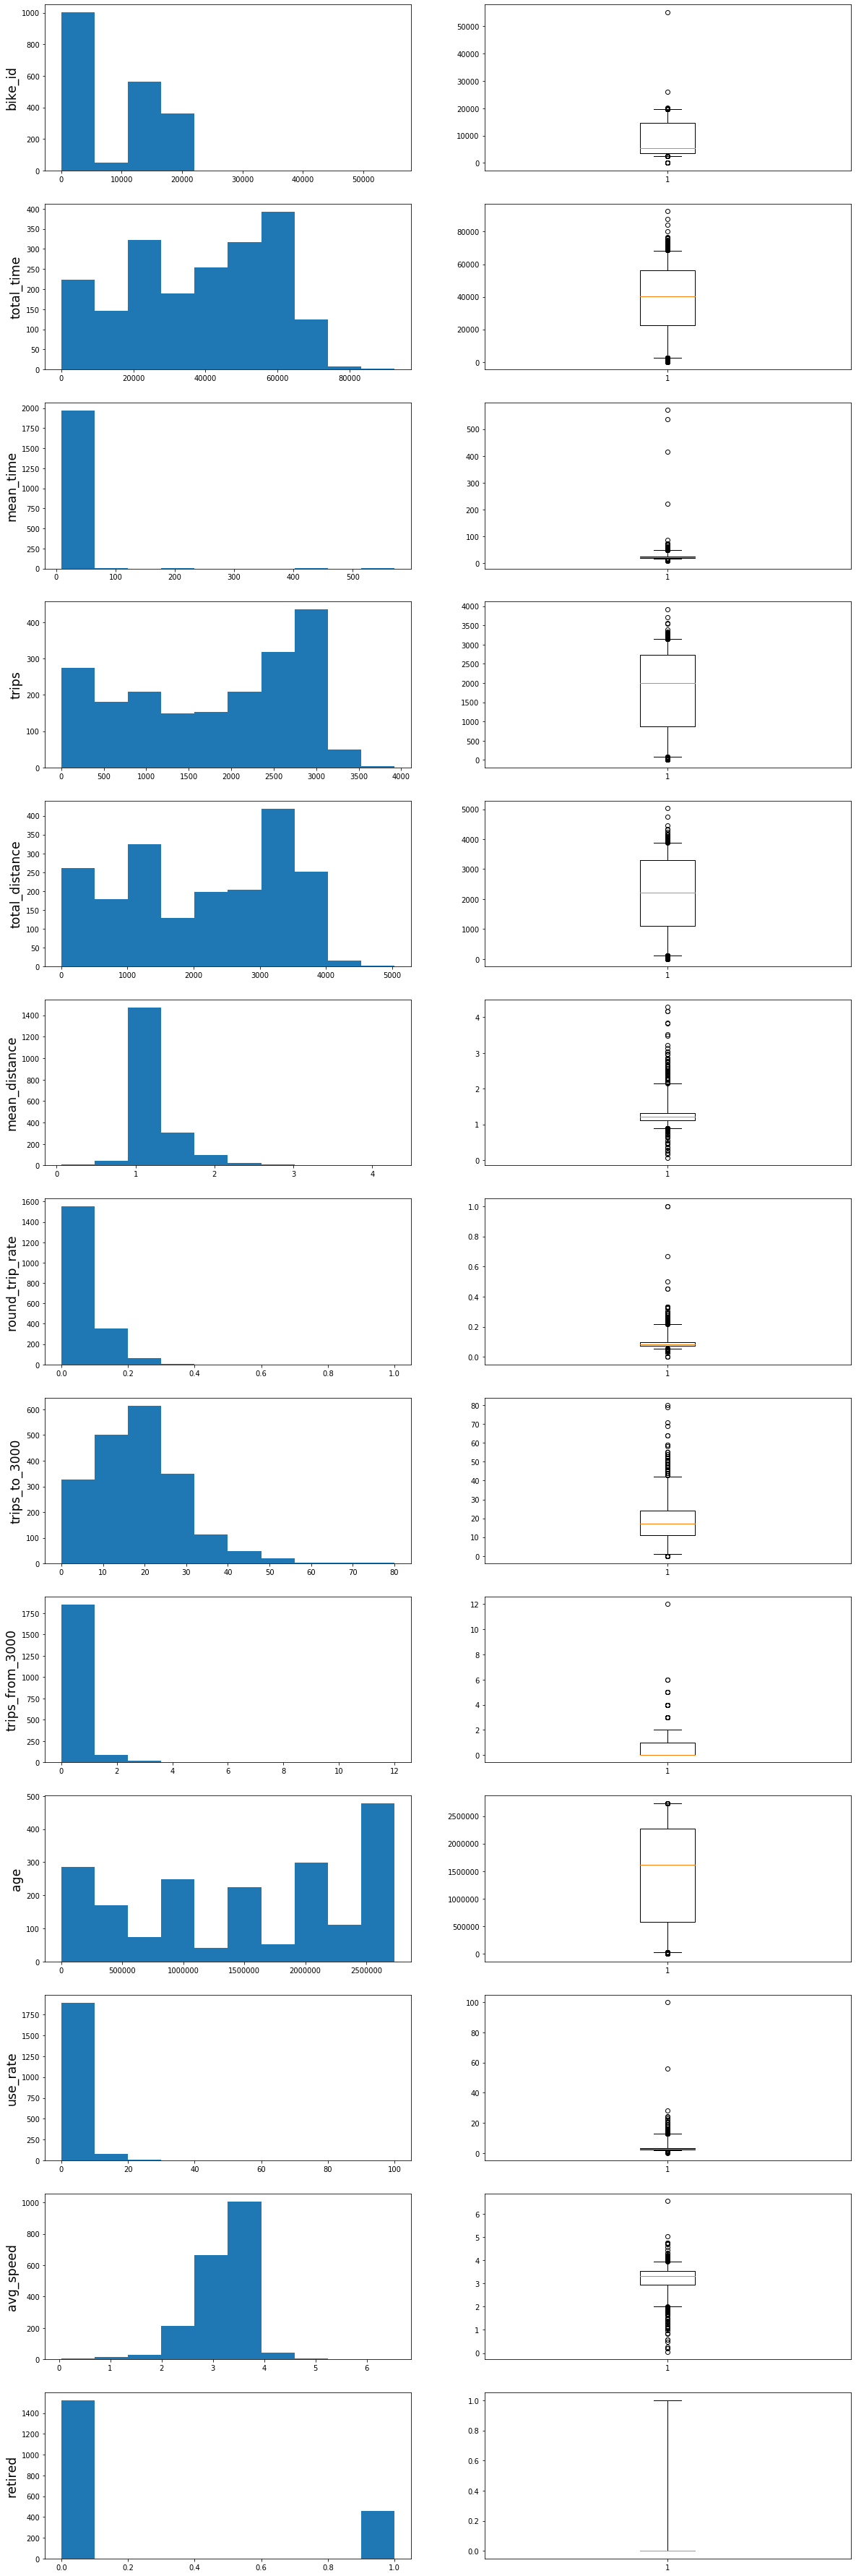

In [59]:
plot_hist_boxplot(bikes.select_dtypes(include='number'))

/home/owen/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/owen/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


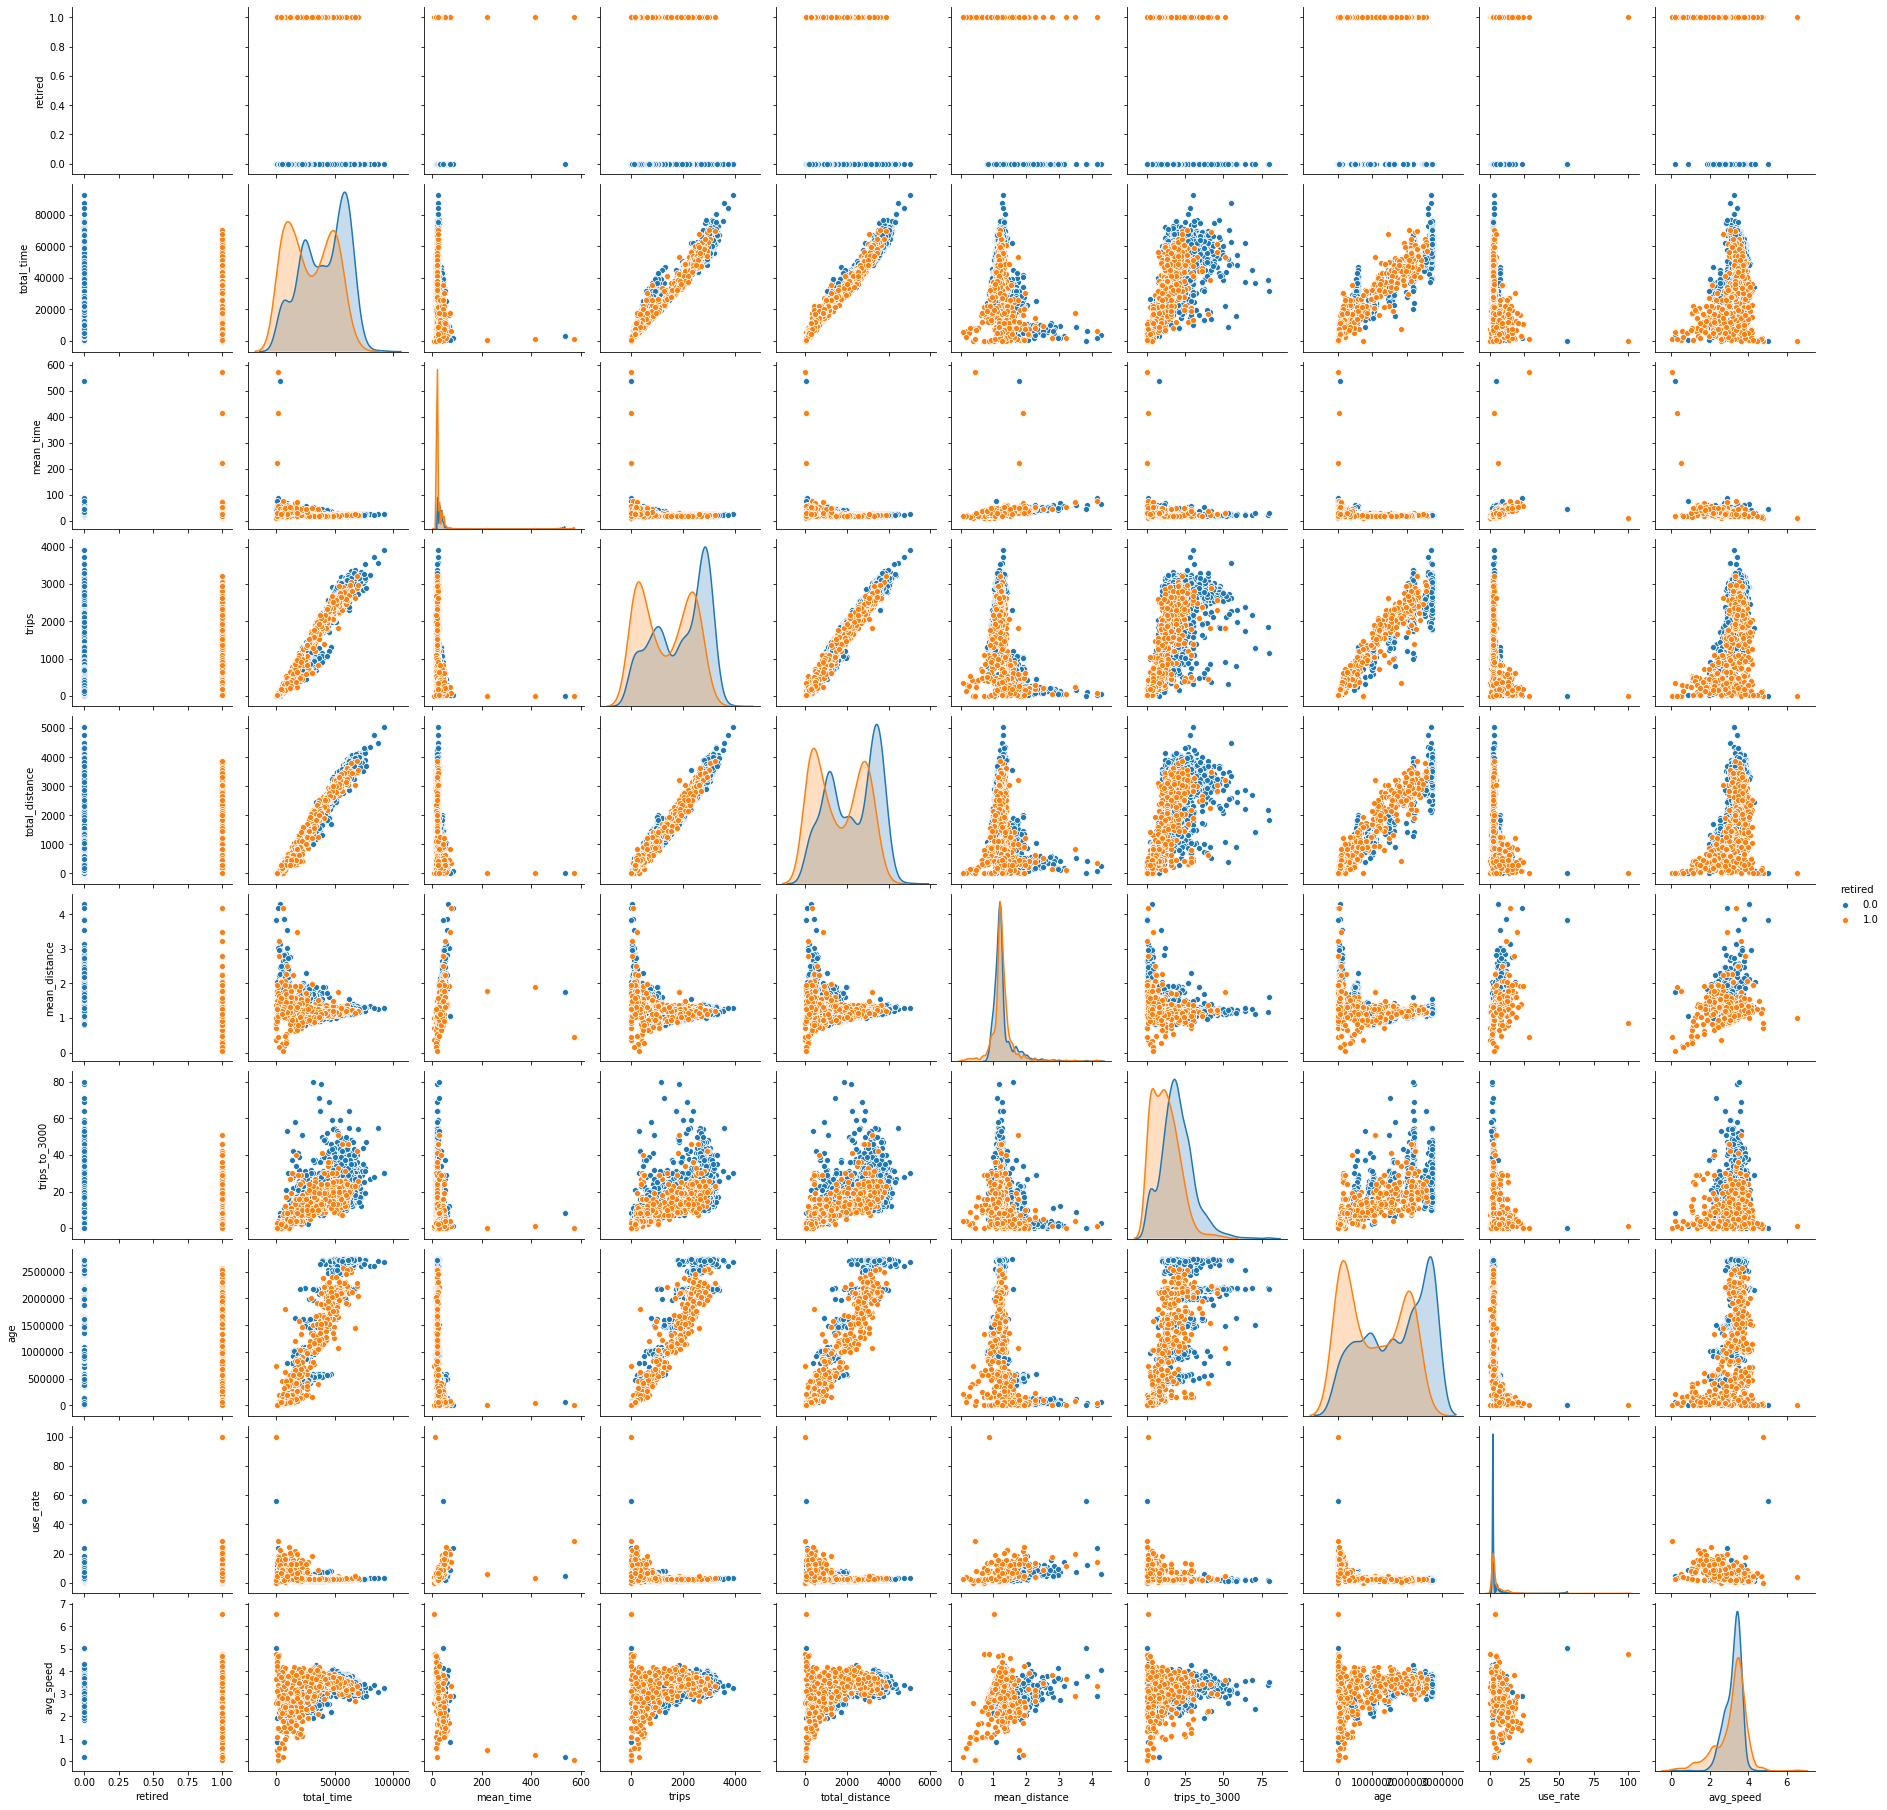

In [68]:
cols = ['retired', 'total_time', 'mean_time', 'trips', 'total_distance',
       'mean_distance', 'trips_to_3000', 'age', 'use_rate', 'avg_speed']
sns.pairplot(bikes, vars=cols, hue='retired')

## Cleaning Outliers


In [69]:
percentiles = [0, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 100]

print('   Percentile   Duration')
for bound in percentiles:
    x = np.percentile(df['duration'], [bound])[0]
    
    print('       {}         {} minutes'.format(str(bound), x))

   Percentile   Duration
       0         1.0 minutes
       1         1.0 minutes
       2.5         2.0 minutes
       5         4.0 minutes
       10         5.0 minutes
       25         7.0 minutes
       50         12.0 minutes
       75         20.0 minutes
       90         38.0 minutes
       95         59.0 minutes
       97.5         90.0 minutes
       99         168.0 minutes
       100         1439.0 minutes


In [70]:
percentiles = [0, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 100]

print('   Percentile   Use Rate')
for bound in percentiles:
    x = np.percentile(bikes['use_rate'], [bound])[0]
    
    print('       {}         {}% '.format(str(bound), round(x, 2)))

   Percentile   Use Rate
       0         0.0% 
       1         1.46% 
       2.5         1.77% 
       5         1.93% 
       10         2.07% 
       25         2.27% 
       50         2.53% 
       75         3.2% 
       90         6.59% 
       95         9.38% 
       97.5         12.78% 
       99         15.88% 
       100         100.0% 


In [71]:
percentiles = [0, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 100]

print('   Percentile   Trips')
for bound in percentiles:
    x = np.percentile(bikes['trips'], [bound])[0]
    
    print('       {}         {} '.format(str(bound), round(x, 2)))

   Percentile   Trips
       0         1.0 
       1         29.78 
       2.5         77.45 
       5         134.0 
       10         223.0 
       25         877.5 
       50         2004.0 
       75         2737.5 
       90         2981.2 
       95         3079.1 
       97.5         3148.55 
       99         3235.22 
       100         3921.0 


In [72]:
bikes[bikes['trips'] < 30]

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,bike_type,round_trip_rate,trips_to_3000,trips_from_3000,age,use_rate,avg_speed,retired
0,1.000,17,8.500,2,0.738,0.369,2019-09-27 13:04:00,2018-05-09 14:40:00,standard,0.500,1.000,0.000,728544,0.002,2.605,1.000
1,3.000,9,9.000,1,0.713,0.713,2018-11-26 14:02:00,2018-11-22 13:53:00,standard,1.000,0.000,0.000,5769,0.156,4.756,1.000
2,14.000,445,222.500,2,3.581,1.790,2018-03-11 16:51:00,2018-03-06 09:23:00,standard,0.000,0.000,0.000,7648,5.819,0.483,1.000
3,42.000,3214,535.667,6,10.589,1.765,2020-06-25 14:07:00,2020-05-05 17:42:00,standard,0.167,8.000,0.000,73225,4.389,0.198,0.000
4,43.000,1141,570.500,2,0.895,0.447,2020-02-06 10:08:00,2020-02-03 15:07:00,standard,0.000,0.000,0.000,4021,28.376,0.047,1.000
5,44.000,1247,415.667,3,5.683,1.894,2020-01-07 19:12:00,2019-12-11 14:19:12,standard,0.333,1.000,0.000,39172,3.183,0.273,1.000
6,47.000,11,11.000,1,0.872,0.872,2019-12-04 13:16:53,2019-12-04 13:05:00,standard,1.000,1.000,0.000,11,100.000,4.756,1.000
932,5348.000,332,19.529,17,25.332,1.490,2016-05-02 20:20:00,2016-04-28 09:45:00,standard,0.176,1.000,0.000,6395,5.192,4.578,1.000
1185,11825.000,65,9.286,7,7.087,1.012,2017-09-27 20:24:00,2017-09-26 15:57:00,standard,0.000,1.000,0.000,1707,3.808,6.542,1.000
1461,14613.000,68,22.667,3,4.122,1.374,2018-08-05 21:02:00,2018-08-03 15:48:00,standard,0.667,1.000,0.000,3194,2.129,3.637,1.000


Based upon a visual inspection of bikes with less than 30 trips I will eliminate only bikes with less than 10 trips. This also includes the single outlier with 100% use time. Here particularly I wish I had more meta data. An inspection of the bike_id values shows that the bikes may belong to series or release groups. There are only a few bikes that do not conform to this pattern, most of which are included in the bikes which have trips fewer than 30. 

In [ ]:
before = len(bikes)

index = bikes[bikes['trips'] < 10].index
bikes.drop(index, inplace=True)

index = bikes[bikes['bike_id'] < 2000].index
bikes.drop(index, inplace=True)

dif = before - len(bikes)
ratio = dif/before * 100
print('Removed {} bikes, {}% of observations'.format(dif, ratio))

In [ ]:
# Write the results to file
bikes.to_csv(r'data/indego/bikewise.csv', index=False)